In [1]:
%matplotlib inline
%matplotlib notebook
import tqdm, copy
import random
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from collections import defaultdict
from overcooked_ai_py.utils import save_pickle
from human_aware_rl.utils import set_global_seed
from human_aware_rl.human.process_dataframes import *
from human_aware_rl.human.data_processing_utils import JS_LAYOUT_NAME_TO_PYTHON_NAME

set_global_seed(1884)

/Users/micah/miniconda3/envs/hrc/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/micah/miniconda3/envs/hrc/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/micah/miniconda3/envs/hrc/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/micah/miniconda3/envs/hrc/lib/python3.7/site-

## NeurIPS data

## Calculate H+H performance over 400 timesteps

In [2]:
all_trials = pd.read_csv("data/human/anonymized/trials_hh.csv", header=0)

In [3]:
clip_400 = True
main_trials = format_hh_trials_df(all_trials, clip_400)
clean_trials = remove_rounds_with_low_rewards(main_trials, min_hh_rew_per_scenario, clip_400)
scenario_rews, worker_rews = get_trials_scenario_and_worker_rews(clean_trials)
hh_performance = get_dict_stats(scenario_rews)

Layouts found ['asymmetric_advantages' 'coordination_ring' 'cramped_room' 'random0'
 'random3']


/Users/micah/Developer/Research/CHAI/human_aware_rl/human_aware_rl/human/process_dataframes.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_trials['reward_norm'] = np.where(main_trials['reward'] != 0.0, main_trials['reward'] * 4.0, 0.0)


In [4]:
clean_trials

,Unnamed: 0,Unnamed: 0.1,cur_gameloop,datetime,is_leader,joint_action,layout,layout_name,next_state,reward,...,state,time_elapsed,time_left,is_wait,completed,run,workerid_num,reward_norm,cur_gameloop_total,reward_norm_total
7215,7215,22170,0.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [6, 2], 'orientation...",0.0,...,"{'players': [{'position': [6, 2], 'orientation...",0.151,180.0,True,True,run-1,1,0.0,401,180.0
7216,7216,22171,1.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [6, 2], 'orientation...",0.0,...,"{'players': [{'position': [6, 2], 'orientation...",0.303,180.0,True,True,run-1,1,0.0,401,180.0
7217,7217,22172,2.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [6, 2], 'orientation...",0.0,...,"{'players': [{'position': [6, 2], 'orientation...",0.451,180.0,True,True,run-1,1,0.0,401,180.0
7218,7218,22173,3.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [6, 2], 'orientation...",0.0,...,"{'players': [{'position': [6, 2], 'orientation...",0.601,179.0,True,True,run-1,1,0.0,401,180.0
7219,7219,22174,4.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [6, 2], 'orientation...",0.0,...,"{'players': [{'position': [6, 2], 'orientation...",0.752,179.0,True,True,run-1,1,0.0,401,180.0
7220,7220,22175,5.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [6, 2], 'orientation...",0.0,...,"{'players': [{'position': [6, 2], 'orientation...",0.901,179.0,True,True,run-1,1,0.0,401,180.0
7221,7221,22176,6.0,1.557859e+12,True,"[[-1, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [5, 2], 'orientation...",0.0,...,"{'players': [{'position': [6, 2], 'orientation...",1.051,179.0,False,True,run-1,1,0.0,401,180.0
7222,7222,22177,7.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [5, 2], 'orientation...",0.0,...,"{'players': [{'position': [5, 2], 'orientation...",1.202,179.0,True,True,run-1,1,0.0,401,180.0
7223,7223,22178,8.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [5, 2], 'orientation...",0.0,...,"{'players': [{'position': [5, 2], 'orientation...",1.351,179.0,True,True,run-1,1,0.0,401,180.0
7224,7224,22179,9.0,1.557859e+12,True,"[[0, 0], [0, 0]]","['XXXXXXXXX', 'O XSXOX S', 'X P 1 X', 'X2 P...",asymmetric_advantages,"{'players': [{'position': [5, 2], 'orientation...",0.0,...,"{'players': [{'position': [5, 2], 'orientation...",1.502,178.0,True,True,run-1,1,0.0,401,180.0


In [5]:
hh_performance_python = {}
# Prepare hh_performance dict
for layout, layout_performance in copy.deepcopy(hh_performance).items():
    python_layout = JS_LAYOUT_NAME_TO_PYTHON_NAME[layout]
    hh_performance_python[python_layout] = (layout_performance["mean"], layout_performance["standard_error"])

In [6]:
hh_performance_python

{'simple': (97.5, 4.284784125250653),
 'unident_s': (158.33333333333334, 7.9785592313028175),
 'random1': (84.61538461538461, 3.8638645484768066),
 'random3': (66.66666666666667, 3.1426968052735447),
 'random0': (94.0, 8.024961059095551)}

In [7]:
save_pickle(hh_performance_python, "data/human/anonymized/hh_performance")

## Analyze full H-H trajectories

In [8]:
clip_400 = False
main_trials = format_hh_trials_df(all_trials, clip_400)
print("Unique traj lengths", np.unique(main_trials["cur_gameloop_total"]))
clean_trials = remove_rounds_with_low_rewards(main_trials, min_hh_rew_per_scenario, clip_400)
print("Unique traj lengths after removing low-reward", np.unique(clean_trials["cur_gameloop_total"]))

Layouts found ['asymmetric_advantages' 'coordination_ring' 'cramped_room' 'random0'
 'random3']
Unique traj lengths [ 644  975 1132 1136 1139 1143 1181 1191 1192 1194 1197 1199 1201 1203
 1204]
Unique traj lengths after removing low-reward [1132 1136 1139 1143 1191 1192 1194 1197 1199 1203 1204]


In [9]:
# Used this script to find a reproducible split with desirable properties
# (test dataset being slightly better than train dataset)

# seeds_for_good_splits = []
# for i in trange(1, 10000):
#     set_global_seed(i)
#     cleaned_trials_dict = train_test_split(clean_trials)
#     if cleaned_trials_dict is not None:
#         seeds_for_good_splits.append(i)

asymmetric_advantages 9 520 8 534
coordination_ring 8 305 8 307
cramped_room 8 350 8 360
random0 6 337 6 340
random3 8 239 7 248

In [10]:
cleaned_trials_dict = train_test_split(clean_trials, print_stats=True)

asymmetric_advantages 9 520 8 534
coordination_ring 8 305 8 307
cramped_room 8 350 8 360
random0 6 337 6 340
random3 8 239 7 248


In [11]:
layouts = np.unique(clean_trials['layout_name'])
train_trials = pd.concat([cleaned_trials_dict[layout]["train"] for layout in layouts])
test_trials = pd.concat([cleaned_trials_dict[layout]["test"] for layout in layouts])
clean_trials = pd.concat([train_trials, test_trials])

In [12]:
[len(cleaned_trials_dict[layout]["train"]) for layout in layouts], [len(cleaned_trials_dict[layout]["test"]) for layout in layouts]

([10768, 9619, 9564, 7151, 9627], [9617, 9562, 9626, 7224, 8344])

In [13]:
main_trials.to_pickle("data/human/anonymized/clean_main_trials.pkl")
train_trials.to_pickle("data/human/anonymized/clean_train_trials.pkl")
test_trials.to_pickle("data/human/anonymized/clean_test_trials.pkl")

# Getting stats and visualizing trajectories

In [14]:
scenario_rews, worker_rews = get_trials_scenario_and_worker_rews(clean_trials)
get_dict_stats(scenario_rews)

{'cramped_room': {'mean': 355.0,
  'standard_error': 16.345871038277526,
  'max': 480.0,
  'n': 16},
 'asymmetric_advantages': {'mean': 527.0588235294117,
  'standard_error': 40.92160372137994,
  'max': 820.0,
  'n': 17},
 'coordination_ring': {'mean': 306.25,
  'standard_error': 16.929887588226922,
  'max': 420.0,
  'n': 16},
 'random3': {'mean': 244.0,
  'standard_error': 11.95547294477861,
  'max': 340.0,
  'n': 15},
 'random0': {'mean': 338.3333333333333,
  'standard_error': 24.433393966879443,
  'max': 480.0,
  'n': 12}}

In [15]:
all_workers = list(worker_rews.keys())
all_workers

[1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23]

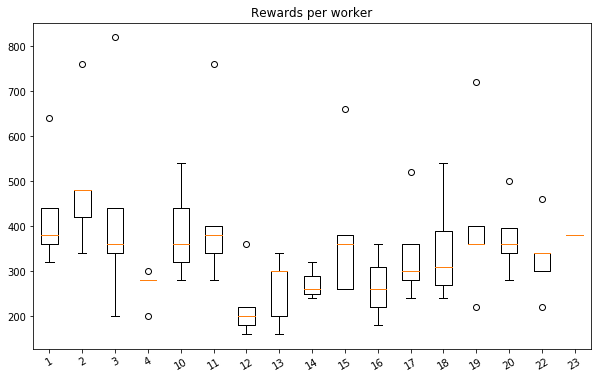

In [16]:
plt.figure(figsize=(10, 6))
plt.title("Rewards per worker")
plt.boxplot(list(worker_rews.values()), labels=list(worker_rews.keys()))
plt.xticks(rotation=30)
plt.show()

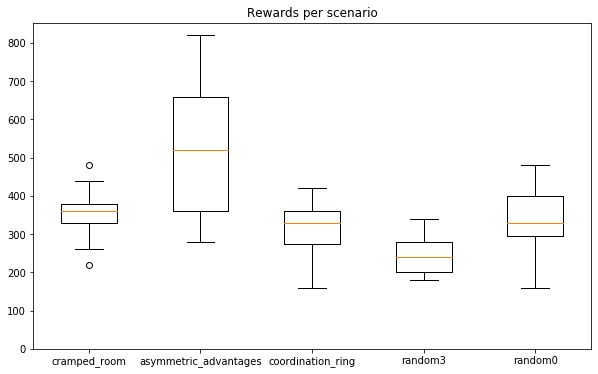

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Rewards per scenario")
plt.boxplot(list(scenario_rews.values()), labels=list(scenario_rews.keys()))
plt.ylim(0,)
plt.show()

In [18]:
# save_trial(main_trials, "debugqfXCQ", "random1")

In [19]:
display_interactive_by_layout(main_trials, 'random3', limit=2)

X X X P P X X X 
X             X 
D   X X X X   S 
X ↑1        ↑0X 
X X X O O X X X 

Joint Action: ('stay', 'stay') 	 Score: 0


Output()

IntSlider(value=0, max=1203)

In [20]:
display_interactive_by_workerid(main_trials, 12)

X X X P X 
O   X ↑0P 
O ↑1X   X 
D   X   X 
X X X S X 

Joint Action: ('stay', 'stay') 	 Score: 0


Output()

IntSlider(value=0, max=1203)